In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.jla_supernovae.jla_simulator as jla
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
from scipy.linalg import block_diag
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP THE PRIOR ###

# Prior over theta
lower = np.array([0, -1.5])
upper = np.array([0.6, 0])
prior_covariance = np.diag([0.4, 0.75])**2
prior_covariance[0,1] = prior_covariance[1,0] = -0.8*0.4*0.75
prior_mean = np.array([  0.3  ,  -0.75])
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Prior over eta (nuisances)
eta_lower = np.array([-20, 0, 0, -0.5])
eta_upper = np.array([-18, 1, 6, 0.5])
eta_mean = np.array([-19.05 ,   0.125,   2.6  ,  -0.05 ])
eta_covariance = np.diag([0.1, 0.025, 0.25, 0.05])**2
eta_prior = priors.TruncatedGaussian(eta_mean, eta_covariance, eta_lower, eta_upper)

# Joint prior over nuisances and interesting parameters
joint_lower = np.concatenate([lower, eta_lower])
joint_upper = np.concatenate([upper, eta_upper])
joint_mean = np.concatenate([prior_mean, eta_mean])
joint_covariance = block_diag(prior_covariance, eta_covariance)
joint_prior = priors.TruncatedGaussian(joint_mean, 
                                       joint_covariance,
                                       joint_lower,
                                       joint_upper)

In [3]:
### SET UP FOR SIMULATION CODE ###

JLASimulator = jla.JLA_Model()

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch):
    
    # Draw nuisances from prior
    eta_prior = simulator_args[0]
    eta = eta_prior.draw()
    
    return JLASimulator.simulation(np.concatenate([theta, eta]), seed)

# Arguments for simulator
simulator_args = [eta_prior]

/Users/justinalsing/Dropbox/science/delfi/master/delfi/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.20181324,  -0.74762939])
eta_fiducial = np.array([-19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Expected data (mean) and covariance
mu = JLASimulator.apparent_magnitude(np.concatenate([theta_fiducial, eta_fiducial]))
Cinv = JLASimulator.Cinv

# Calculate derivatives of the expected power spectrum
h = np.array(abs(np.concatenate([theta_fiducial, eta_fiducial])))*0.01
dmudt = JLASimulator.dmudt(np.concatenate([theta_fiducial, eta_fiducial]), h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Gaussian(len(JLASimulator.data), np.concatenate([theta_fiducial, eta_fiducial]), mu = mu, Cinv = Cinv, dmudt = dmudt, prior_mean = joint_mean, prior_covariance = joint_covariance)

# Compute the Fisher matrix
Compressor.compute_fisher()

# Pull out Fisher matrix inverse
Finv = Compressor.Finv[0:2,0:2]

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.projected_scoreMLE(d, np.arange(2,6))
compressor_args = None

In [5]:
data = compressor(JLASimulator.data, compressor_args)

In [6]:
# Create the neural density estimator (MDN)
NDEs = [ndes.MixtureDensityNetwork(n_inputs=2, n_outputs=2, n_components=3, n_hidden=[10,10], activations=[tf.tanh, tf.tanh])]
#MDN = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=2, n_outputs=2, n_hiddens=[50,50], 
#                                               n_mades=1, act_fun=tf.tanh)
# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, NDEs, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'w_0'], 
                       results_dir = "simulators/jla_supernovae/results_marginal/mdn",
                       input_normalization="fisher")

In [7]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining()

Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


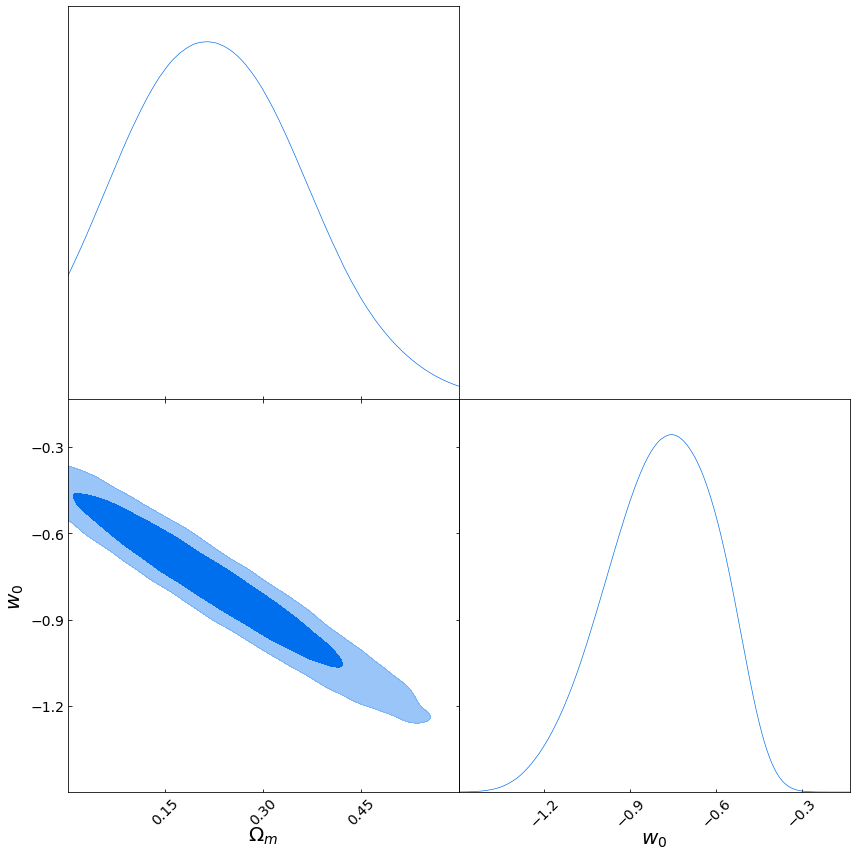

Population 1/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


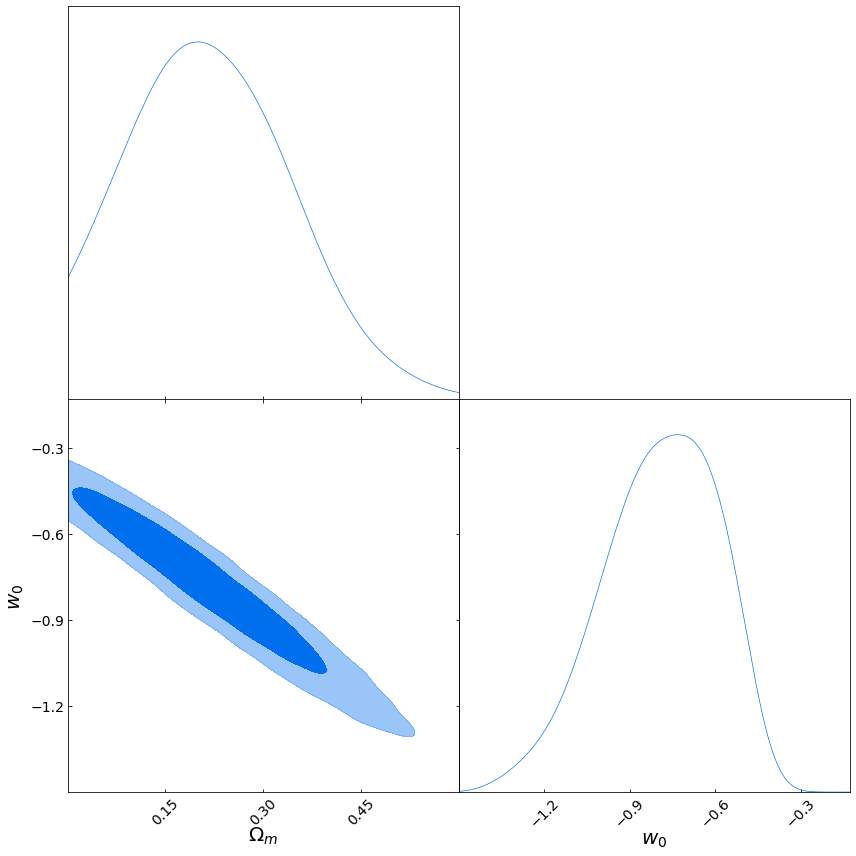

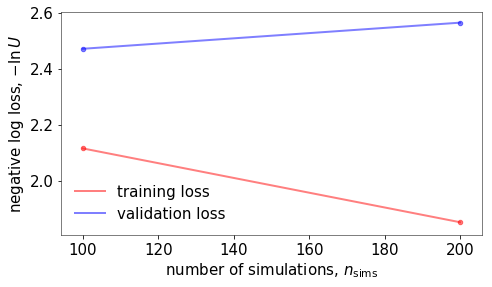

Population 2/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


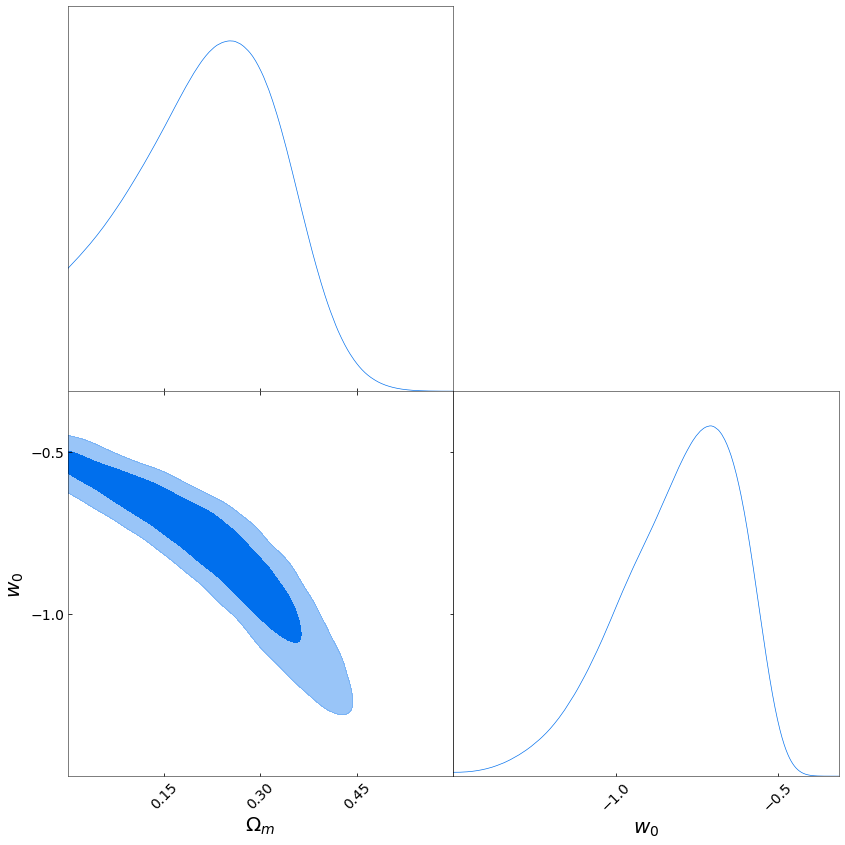

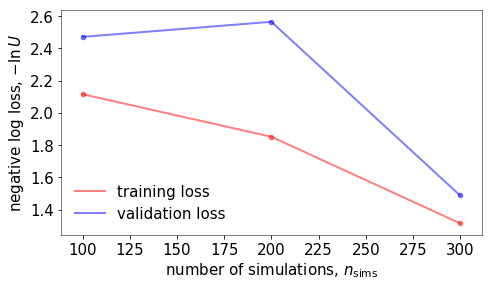

Population 3/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


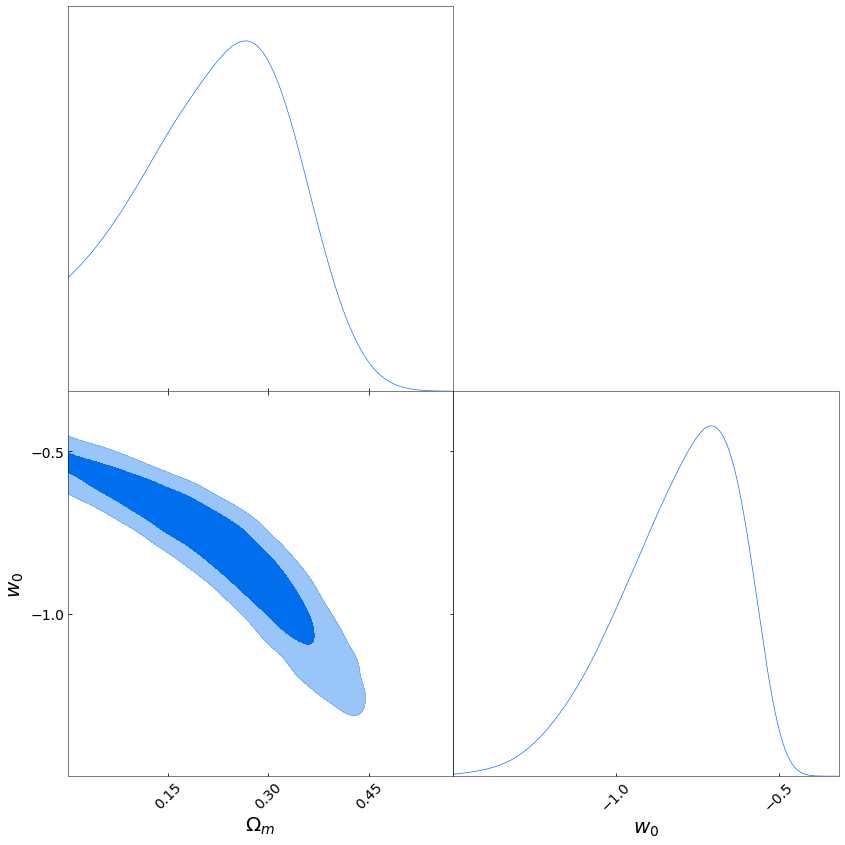

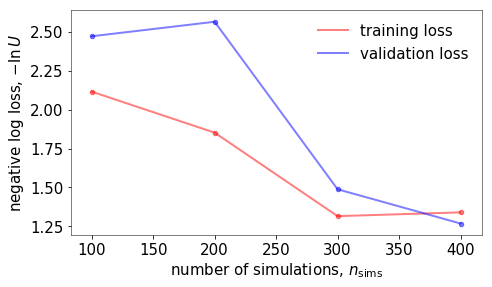

Population 4/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


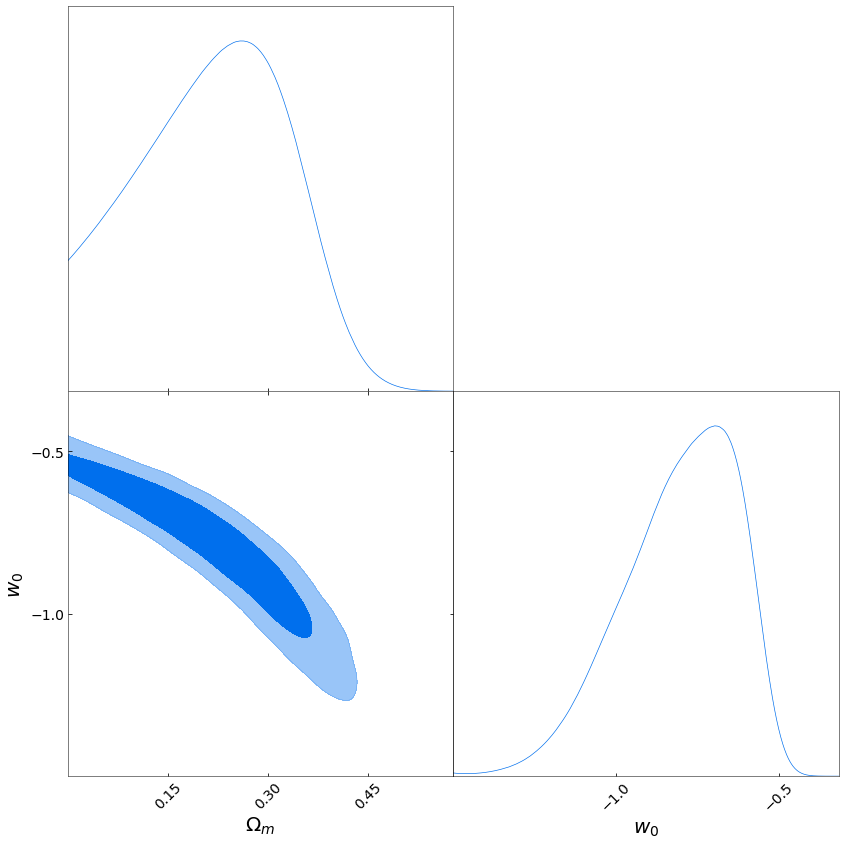

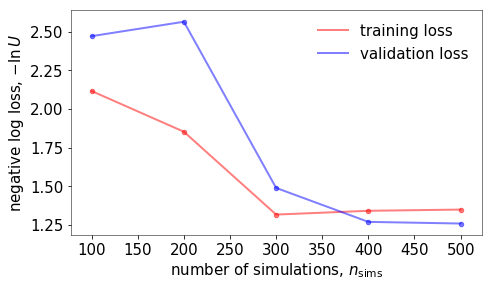

Population 5/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


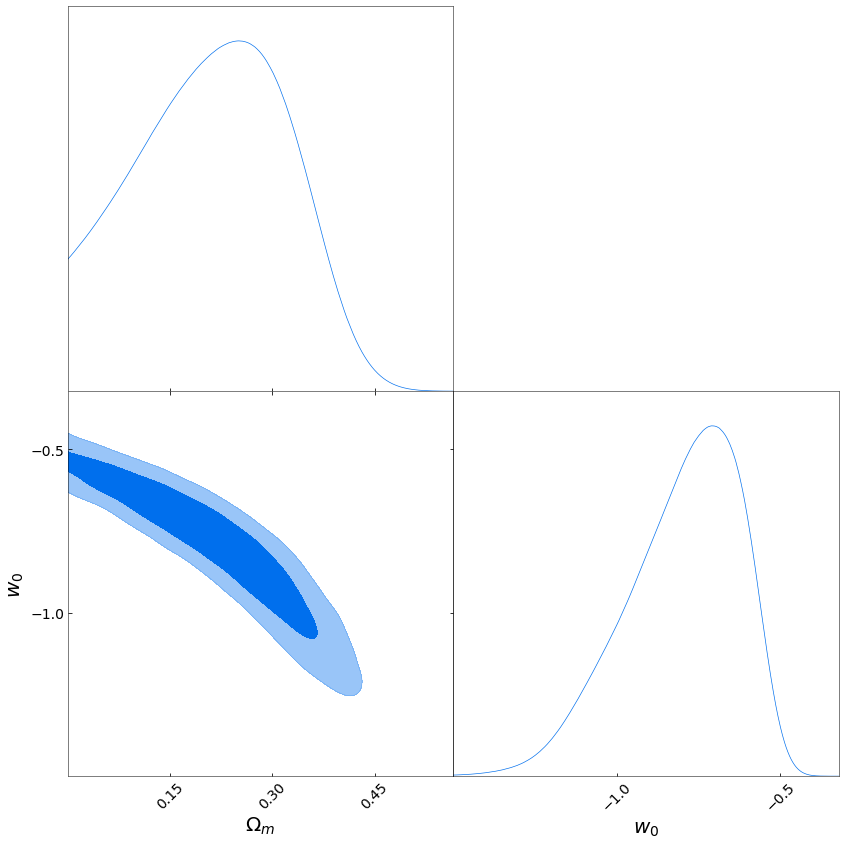

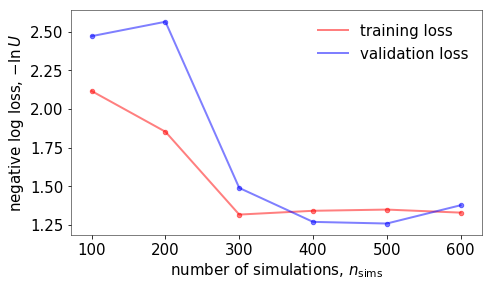

Population 6/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


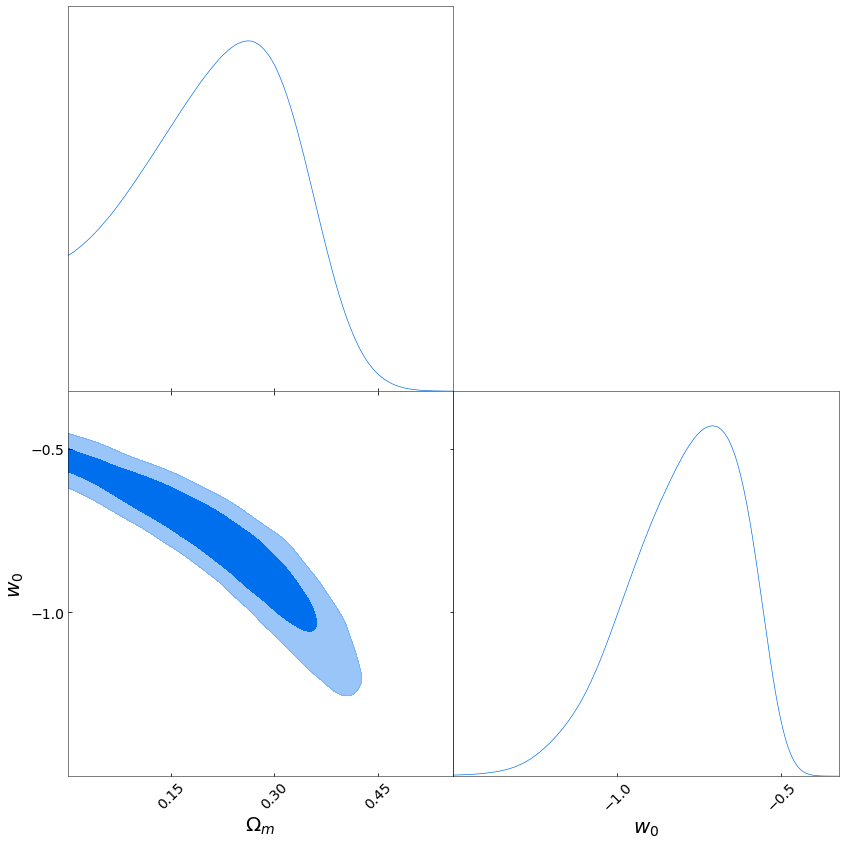

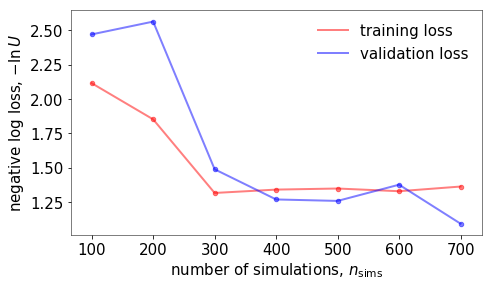

Population 7/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


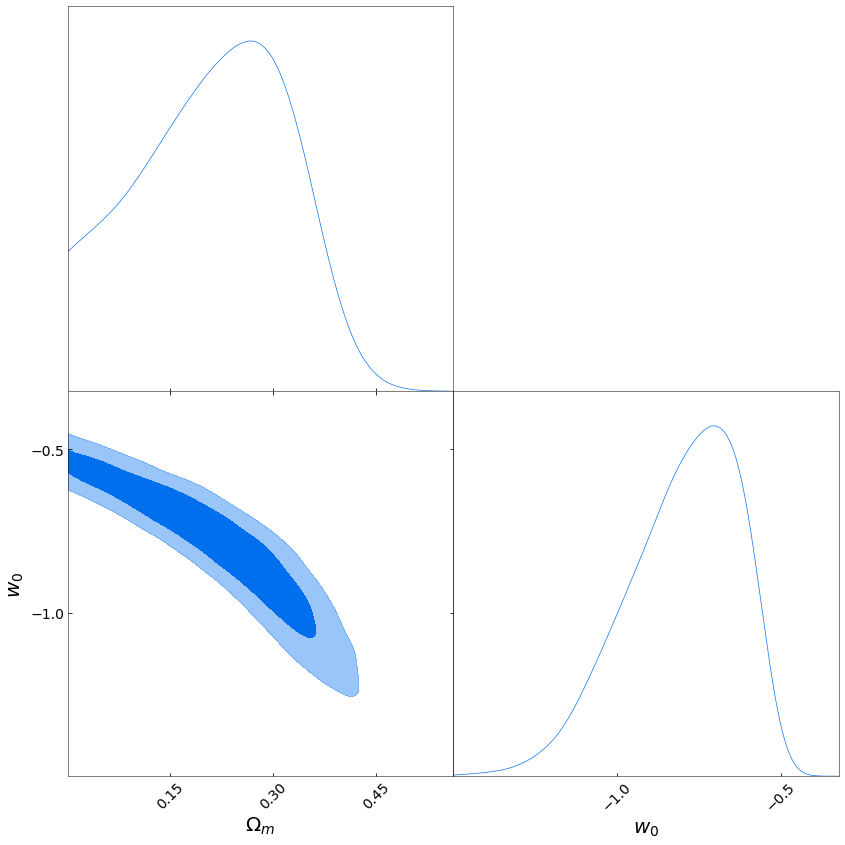

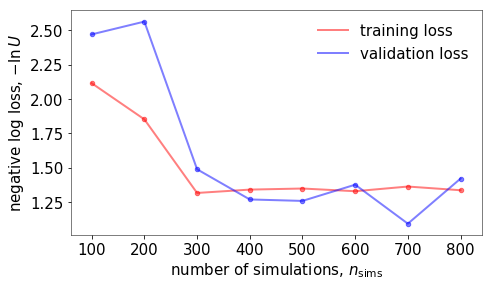

Population 8/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


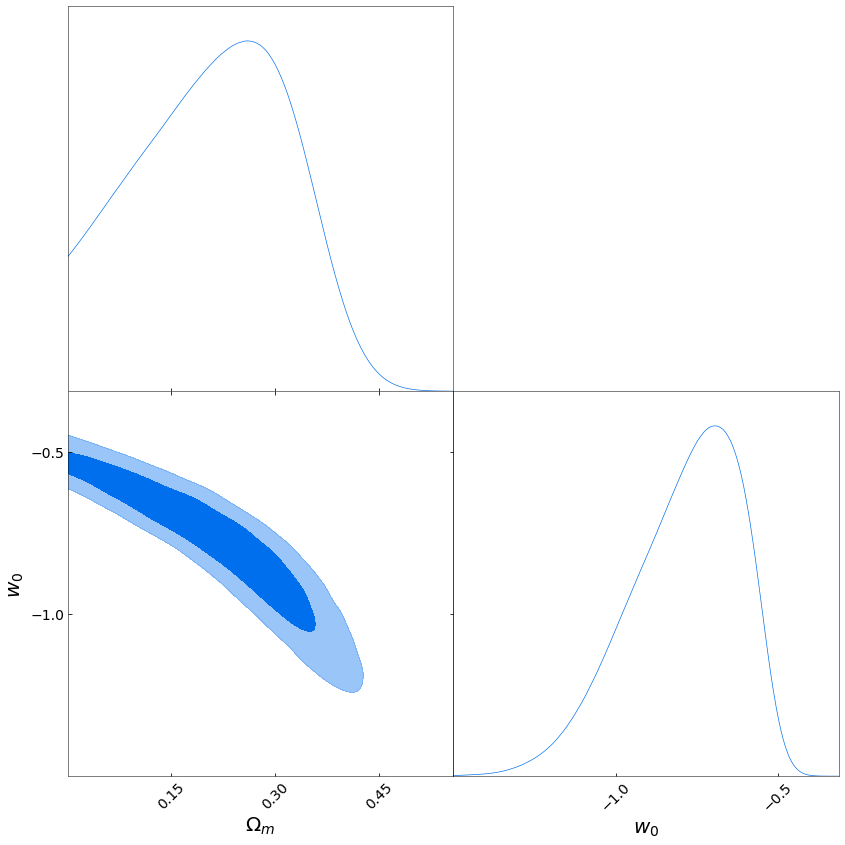

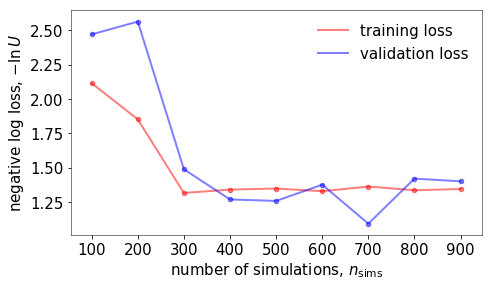

Population 9/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


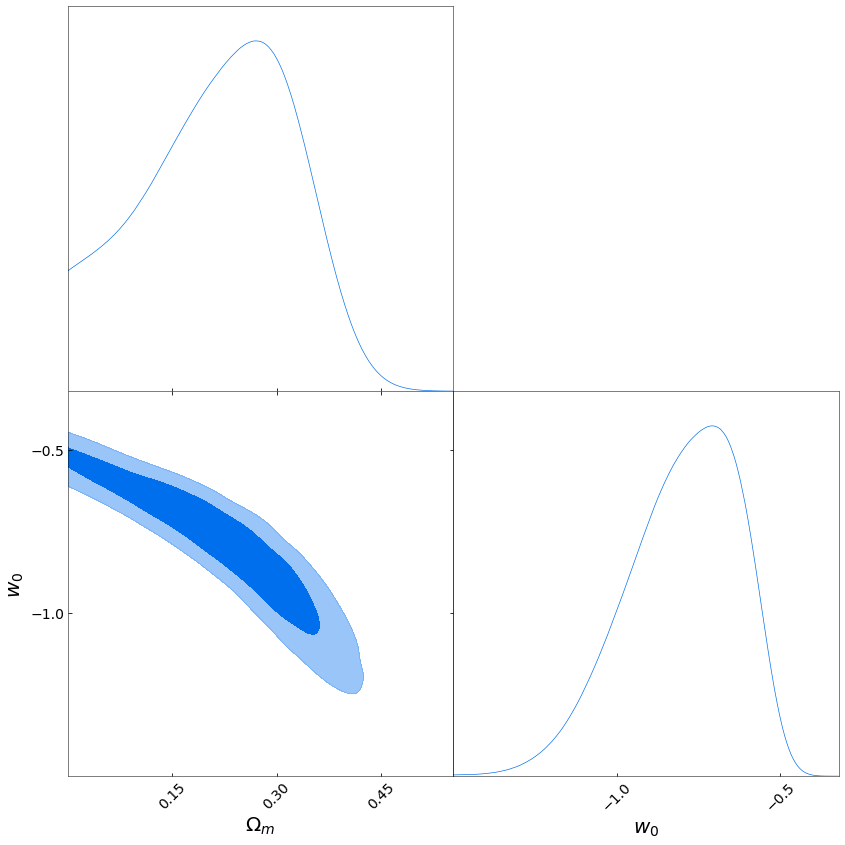

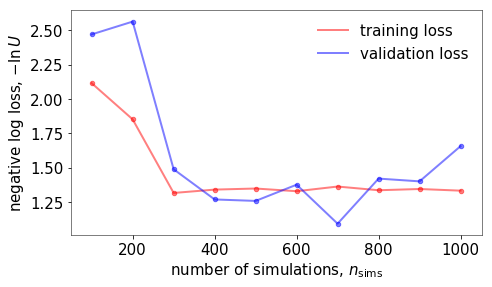

Population 10/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


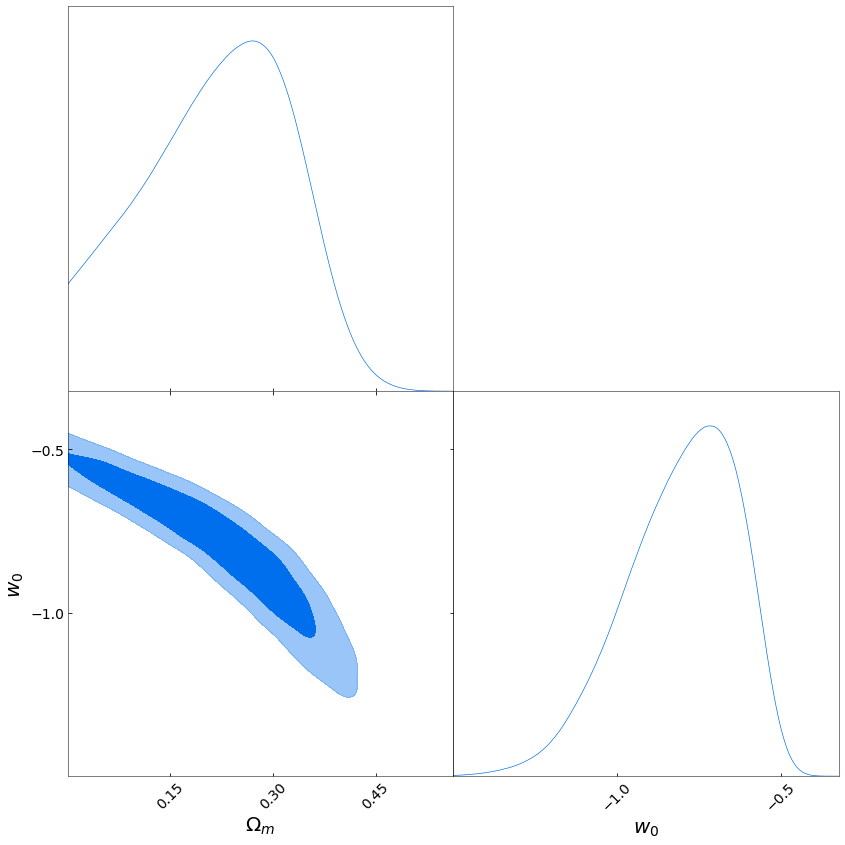

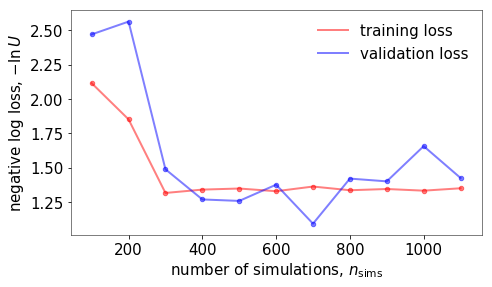

Population 11/11
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


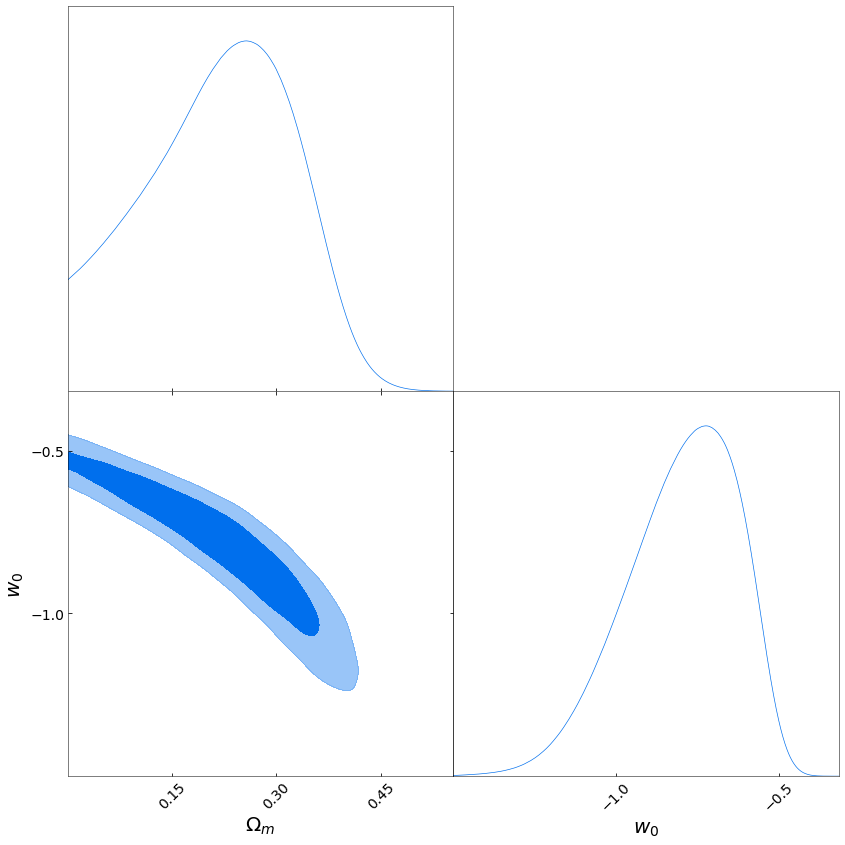

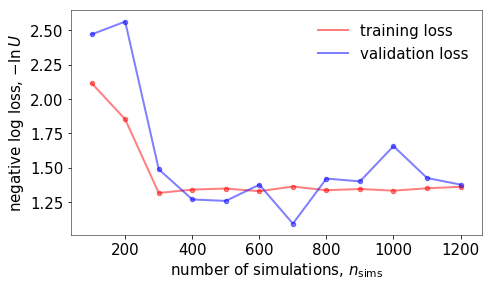

In [8]:
# Initial samples, batch size for population samples, number of populations
n_initial = 100
n_batch = 100
n_populations = 11

# Initial proposal density
proposal = priors.TruncatedGaussian(data, np.eye(2)*np.diag(Finv), lower, upper)

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10, simulator_args=simulator_args, proposal=proposal)

Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


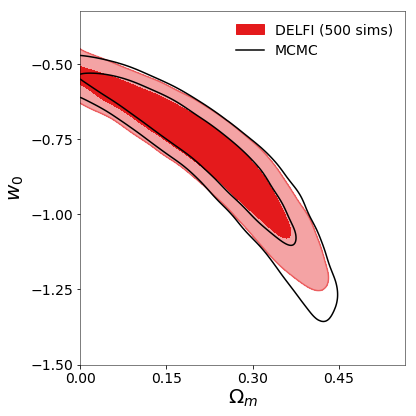

In [9]:
# Plot against MCMC chain for comparison
import getdist
from getdist import plots, MCSamples

# Import the MCMC chain and intermediate delfi chain
emcee_chain = np.loadtxt('simulators/jla_supernovae/emcee_samples.dat')
delfi_chain = np.loadtxt('simulators/jla_supernovae/results_marginal/mdnposterior_samples_5.dat')

plt.close()
columnwidth = 10 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 6)
g.settings.legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=14
g.settings.lab_fontsize=20
g.settings.lw_contour = 1.5

names = ['\Omega_m', 'w_0']
labels = ['\Omega_m', 'w_0']
ranges = dict(zip(names, [ [lower[i], upper[i]] for i in range(len(names)) ]))

samples = [delfi_chain, emcee_chain[:,0:2]]
mc_samples = [MCSamples(samples=s, names = names, labels = labels, ranges = ranges) for s in samples]

g.plot_2d(mc_samples, names, filled=[True,False], colors=['#E41A1C','black'])
g.add_legend(legend_labels=['DELFI (500 sims)', 'MCMC'])
plt.tight_layout()
plt.show()
#plt.savefig('../../paper_II/plots/jla_2d_comparison.pdf')

In [75]:
# Covariance
C_nuisances = Compressor.Finv[2:,2:] - np.dot(np.dot(Compressor.Finv[0:2,2:].T, np.linalg.inv(Compressor.Finv[0:2,0:2])), Compressor.Finv[0:2, 2:])
C_inv_nuis = np.linalg.inv(C_nuisances)
sqrt_det_C_inv_nuis = 1./np.sqrt(np.linalg.det(C_nuisances))

# Conditional Gaussian
def conditional_gaussian(eta, theta):
    
    # Conditional mean
    mu = eta_fiducial + np.dot(Compressor.Finv[2:, 0:2], np.dot(np.linalg.inv(Compressor.Finv[0:2,0:2]), theta - theta_fiducial))
    
    return sqrt_det_C_inv_nuis*np.exp(-0.5*np.dot(eta - mu, np.dot(C_inv_nuis, eta - mu)))

# Blackwell-Rao estimator
theta_samples = delfi_chain[0:1000,0:2]
def log_like(eta):
    
    return np.log(np.sum( np.array([conditional_gaussian(eta, theta_samples[i]) for i in range(len(theta_samples))]))) + eta_prior.logpdf(eta)

In [76]:
%timeit log_like(eta_fiducial)

30.2 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
import emcee
from scipy.stats import multivariate_normal

# Set up the sampler
sampler = emcee.EnsembleSampler(100, 4, log_like)

# Burn-in chain
x0 = np.array([multivariate_normal.rvs(mean=eta_fiducial, cov=Compressor.Finv[2:,2:], size=100)])[0]
pos, prob, state = sampler.run_mcmc(x0, 50)
sampler.reset()

# Main chain
sampler.run_mcmc(pos, 300)

nuis_chain = sampler.flatchain

Removed no burn in
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


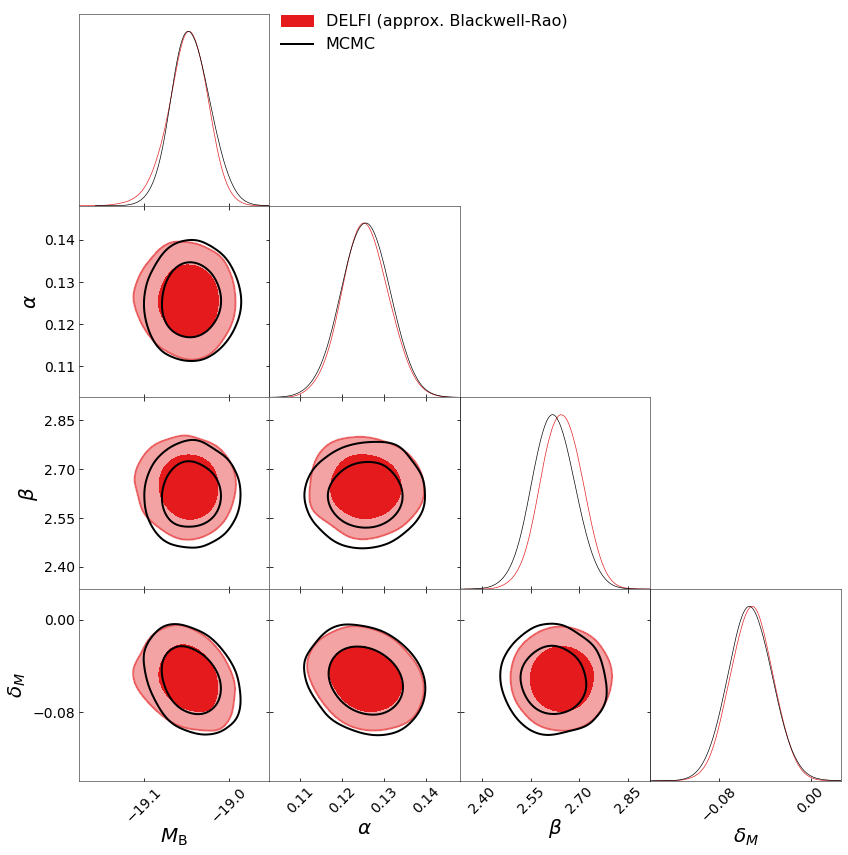

In [80]:
# Plot against MCMC chain for comparison
import getdist
from getdist import plots, MCSamples

# Import the MCMC chain and intermediate delfi chain
emcee_chain = np.loadtxt('simulators/jla_supernovae/emcee_samples.dat')[:,2:]
#delfi_chain = np.loadtxt('simulators/jla_supernovae/results_marginal/mdnposterior_samples_5.dat')

plt.close()
columnwidth = 10 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 6)
g.settings.legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=14
g.settings.lab_fontsize=20
g.settings.lw_contour = 1.5
g.settings.lw_contour = 2


names = ['M_\mathrm{B}', '\alpha', '\beta', '\delta_M']
labels = ['M_\mathrm{B}', '\\alpha', '\\beta', '\\delta_M']
ranges = dict(zip(names, [ [eta_lower[i], eta_upper[i]] for i in range(len(names)) ]))

samples = [nuis_chain, emcee_chain]
mc_samples = [MCSamples(samples=s, names = names, labels = labels, ranges = ranges) for s in samples]

# Triangle plot
g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.settings.lw_contour = 2

g.triangle_plot(mc_samples, filled=[True,False], contour_colors=['#E41A1C','black'], legend_labels=['DELFI (approx. Blackwell-Rao)', 'MCMC'], )
for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)

#g.triangle_plot(mc_samples, names, filled=[True,False], colors=['#E41A1C','black'], legend_labels=['DELFI (approx. Blackwell-Rao)', 'MCMC'])
#plt.tight_layout()
plt.show()
#plt.savefig('../../paper_II/plots/jla_2d_comparison.pdf')